# Visualization of worm KO metabolomic data from Artyukhin et al. 2018

Data from J Am Chem Soc. 2018 February 28; 140(8): 2841–2852. doi:10.1021/jacs.7b11811.

Metabolomic “Dark Matter” Dependent on Peroxisomal β- Oxidation in Caenorhabditis elegans. 
Alexander B. Artyukhin*,†, Ying K. Zhang†, Allison E. Akagi‡, Oishika Panda†, Paul W. Sternberg‡, and Frank C. Schroeder*,†

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import json

sys.path.append("/Users/lish/li.github/Li_CVK/lcvk")
from polarPlot import *
from metModels import *

In [2]:
# Get metabolic model
model = json.load(open('../data/metabolicModel_RECON3D_20210510.json'))
print(model['meta_data'])
model = json_convert_azmuth_mummichog(model)
pathwayslist = model['metabolic_pathways']

{'species': 'human', 'version': '', 'sources': ['https://github.com/VirtualMetabolicHuman, retrieved 2021-05-08'], 'status': '', 'last_update': '20210510', 'note': 'RECON3D cloned from https://github.com/VirtualMetabolicHuman, 2021-05-08.\nCompounds are decompartmentalized, but Reactions are not. \nThe redundant metabolites will be merged ad hoc when pathways and reactions are pulled.\n'}


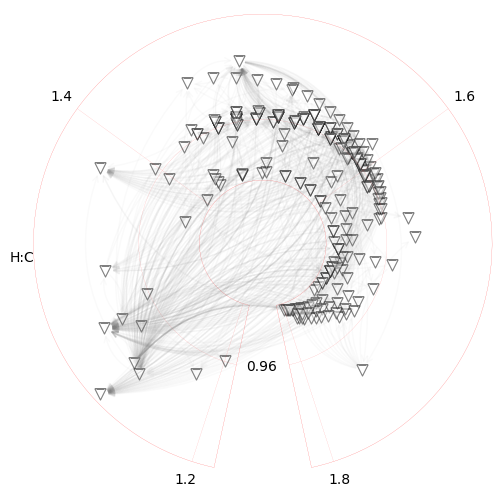

In [ ]:
# this is the human pathway
P = pathwayslist[26]
filename = clean_pathway_name(P['name'])
pathway_nodes, pathway_edges = [model['Compounds'][x] for x in P['cpds']], P['edges']
cplot_LCVK_pathway(pathway_nodes, pathway_edges, formula='charged_formula', cpd_name='id',
                    title='',  ydata='ratio_NOPS', 
                    width=6, height=6, 
                    rotation=30, show_names=False, yLabel_off=True,
                    marker='v', facecolors='w', linewidths=.8, edgecolors='k', s=64, edge_alpha=0.04,
                    outfile= '../output/Fig5____a____' +filename+'.pdf')

In [11]:
pathway_nodes[22]

{'id': 'CE7109',
 'name': '5(S),6(S)-Epoxy-15(R)-HEPE',
 'identifiers': {},
 'neutral_formula': '',
 'charge': -1,
 'charged_formula': 'C20H27O4',
 'neutral_mono_mass': 0.0,
 'SMILES': '',
 'inchi': '',
 'ratio_H_C': 1.35,
 'ratio_O_C': 0.2,
 'ratio_N_C': 0.0,
 'ratio_NOPS': 0.26666666666666666,
 'ccs_offset': 0,
 'centrality': None}

In [4]:
# get data from Table S2
cpds = []
for line in open('../data/Artyukhin2018_S2.tsv').readlines()[1:]:
    a = line.strip().split('\t')
    if len(a) == 3:
        [rt, mz, formula] = a
        formula = formula.replace('"', '').split(';')[0]
        # print(formula)
        if formula[0] == 'C' and formula[-1] == '-':
            cpds.append([rt, mz, formula])
            
print(len(cpds), cpds[:3])

69 [['1.57', '332.17215', 'C15H26NO7-'], ['1.62', '263.11389', 'C11H19O7-'], ['2.19', '249.09825', 'C10H17O7-']]


In [12]:
# test 
get_chnops_ratios('C15H26NO7-')

(1.7333333333333334, 0.4666666666666667, 0.06666666666666667, 0.7)

In [ ]:
# The worm data are given in negative ion formula; and most human data here are charged formula
# Better to convert to neutral formulas for both in proper analysis

worm_nodes = []
for cpd in cpds:
    formula = cpd[2]
    if 'C' in formula and 'H' in formula:
        hc, oc, nc, nops_c, ccs_offset = get_kvli_ratios(formula, 0)
        if hc <= 5:
            worm_nodes.append(
                        { 'id': formula,
                            'ratio_H_C': hc,
                            'ratio_O_C': oc,
                            'ratio_N_C': nc,
                            'ratio_NOPS': nops_c,
                            'ccs_offset': ccs_offset,
                            'centrality': None, # future use
                        }
                    )

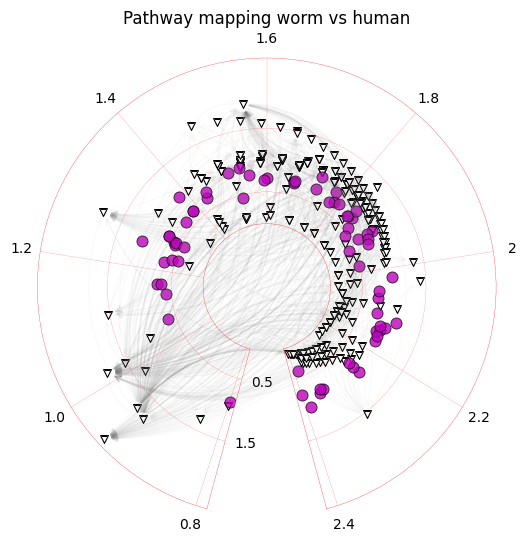

In [21]:
# Plot side by side w/ human pathway 26
# 
pathway_nodes, pathway_edges = [model['Compounds'][x] for x in P['cpds']], P['edges']

pathway_nodes, pathway_edges = calculate_clean_network(pathway_nodes, pathway_edges, 
                                                       formula='charged_formula', max_H_C_allowed=5)

title='Pathway mapping worm vs human' 
outfile= '../output/Fig5____a__both____' + '.pdf'

YMAX = 2.5
min_radius=0
max_radius=2.5
theta_limit = (0.1*np.pi, 1.9*np.pi)
theta_offset = 0.05         # so that nodes do not sit on border lines
hcList = [max(min(x['ratio_H_C'], 2.5), 0.5) for x in pathway_nodes]

hcList = project_hc_data_radial(hcList)
yList = [min(max(x['ratio_NOPS'], min_radius), max_radius) 
            for x in pathway_nodes]

# ticks reverse function of standardize_data
xlabels = [ 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2, 2.2, 2.4]
xticks = project_hc_data_radial(xlabels)

fig = plt.figure(figsize=(6, 6))
ax = fig.subplots(subplot_kw={'projection': 'polar',  } 
)

ax.scatter(hcList, yList, 
           marker='v', facecolors='w', linewidths=.8, edgecolors='k', s=32,
            )
    
layout = dict((x['id'], (hcList[ii], yList[ii])) for ii,x in enumerate(pathway_nodes))   
for edge in pathway_edges: # cleaned edges to use
    ax.annotate("",
        xy=layout[edge[0]], xycoords='data',
        xytext=layout[edge[1]], textcoords='data',
        arrowprops=dict(arrowstyle="->", color="0.5", alpha=0.04,
                        shrinkA=5, shrinkB=5,
                        patchA=None, patchB=None,
                        connectionstyle="arc3,rad=-0.3",
                        ),
        )

# worm data
hcList = project_hc_data_radial([max(min(x['ratio_H_C'], 2.5), 0.5) for x in worm_nodes])
yList = [min(max(x['ratio_NOPS'], min_radius), max_radius) 
            for x in worm_nodes]
ax.scatter(hcList, yList, 
           marker='o', facecolors='m', linewidths=0.6, edgecolors='k', s=64, alpha=0.8,
            )

ax.set_theta_zero_location('S')
ax.set_theta_direction(-1)
ax.set_thetalim((theta_limit[0]-theta_offset, theta_limit[1]+theta_offset))
ax.set_ylim(0, YMAX + 0.1)
ax.set_xticks(xticks)
ax.set_xticklabels([str(x) for x in xlabels])

ax.set_rgrids([0.5, 1.5])
ax.grid(color='r', linewidth=0.1)
for p in ax.spines.values():
    # inner, polar, start, end
    p.set_color('r')
    p.set_linewidth(0.2)

ax.set_rorigin(-1)
# ax.text(1.7, YMAX + .45, "H:C", )
# ax.text(1.96*np.pi, 1.6, "NOPS:C", rotation=285)
ax.set_title(title)
plt.savefig(outfile, dpi=300)

# Conclusion

The worm ascarosides, as indicated by the Artyukhin et al. 2018 paper, are unique to nematodes and not mapped to the human fatty acids. 

But they have "a fatty acid-like side chain of varying length", therefore fall into similar areas on the lCVK map.